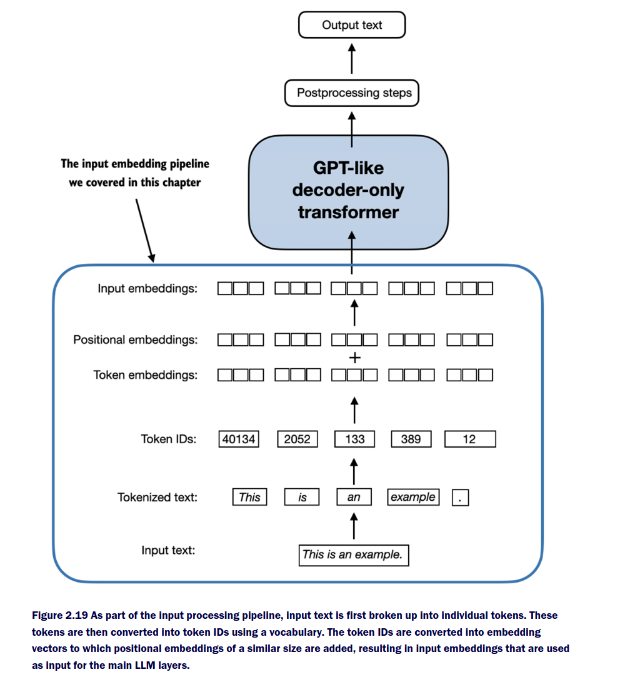

# 2.2 Tokenizing text

First of all we have to load the text (https://en.wikisource.org/wiki/The_Verdict)

In [63]:
# reading the txt file
with open("text.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print("Total number of characters: ", len(raw_text))
print('')
print('Sample of text:')
print(raw_text[:99])
print('')
print('Raw_text type: ',type(raw_text))


Total number of characters:  20480

Sample of text:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 

Raw_text type:  <class 'str'>


Then we have to split the text to obtain a list of tokens. Let's build a basic tokenizer.

In [64]:
# the python library we will use
import re
test = "Hello, world. This is  a test."
result = re.split(r'(\s)', test)
print(result)

['Hello,', ' ', 'world.', ' ', 'This', ' ', 'is', ' ', '', ' ', 'a', ' ', 'test.']


In [65]:
# removing punctuation from word tokens
result = re.split(r'([,.]|\s)', test)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ' ', 'is', ' ', '', ' ', 'a', ' ', 'test', '.', '']


In [66]:
# removing whitespace with the .strip() method which removes leading and trailing whitespace from a string
result = [t for t in result if t.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', 'is', 'a', 'test', '.']


In [67]:
# let's modify this pipeline so that it works on the test text
text = "Hellp, world. Is this a --test?"
result = re.split(r'([,.;:?_!"()\']|--|\s)', text)
result = [t for t in result if t.strip()]
print(result)

['Hellp', ',', 'world', '.', 'Is', 'this', 'a', '--', 'test', '?']


Now we have to apply this basic tokenizer to our text.

In [68]:
preprocessed = re.split(r'([,.;:?_!"()\']|--|\s)', raw_text)
preprocessed = [t for t in preprocessed if t.strip()]
print(preprocessed)

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself', 'in', 'a', 'villa', 'on', 'the', 'Riviera', '.', '(', 'Though', 'I', 'rather', 'thought', 'it', 'would', 'have', 'been', 'Rome', 'or', 'Florence', '.', ')', '"', 'The', 'height', 'of', 'his', 'glory', '"', '--', 'that', 'was', 'what', 'the', 'women', 'called', 'it', '.', 'I', 'can', 'hear', 'Mrs', '.', 'Gideon', 'Thwing', '--', 'his', 'last', 'Chicago', 'sitter', '--', 'deploring', 'his', 'unaccountable', 'abdication', '.', '"', 'Of', 'course', 'it', "'", 's', 'going', 'to', 'send', 'the', 'value', 'of', 'my', 'picture', "'", 'way', 'up', ';', 'but', 'I', 'don', "'", 't', 'think', 'of', 'that', ',

The way text data is preprocesed strongly depends upon model's application and requirements:
1. **capital letters** could be ignored. But for the purpose of working with LLM, this information is useful for the model to understand differences like proper names versus common names and so on.
2. **spaces** can become important depending on the task. For example a LLM for coding purposes has to learn proper language indentation.

# 2.3 Converting tokens into token IDs

Questo e un passaggio intermedio. Abbiamo bisogno di trasformare i token in numeri. Per fare questo, utilizziamo un dizionario che abbiamo creato ed una particolare implementazione di **one-hot encoding**. L'ID che assegnamo ad ogni token puo essere visto come la posizione non nulla di un vettore one-hot associato al token.

Creiamo una classe con due metodi:
1. `.decode()` prende una striga e rende l'ID di tutte le parole contenute nella stringa
2. `.decode()` prende una serie di ID e rende una stringa formata dai token associati


In [69]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


Per costruire questo primo tokenizer abbiamo bisogno di un vocabolario. Questo agisce da mappa fra lo spazio dei token e quello dei numeri. Ad token in input assegna un ID.

In [70]:
# create a mapping from each word to an integer
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
  print(item)
  if i>= 50:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


Il tokenizer che creiamo prende in input una stringa di testo e la codifica assegnango ad ogni parola un token ID opportuno secondo le parole presenti nel dizionario. Opera anche l'operazione inversa.

In [71]:
# first version of the tokenizer
class SimpleTokenizerV1:
  def __init__(self, vocab):
    # vocab (token -> ID)
    self.str_to_int = vocab
    # inverted vocab (ID -> token)
    self.int_to_string = {i:s for s,i in vocab.items()}

  # text -> IDs
  def encode(self, text):
    preprocessed = re.split(r'([,.;:?_!"()\']|--|\s)', text)
    preprocessed = [
        item.strip() for item in preprocessed if item.strip()
    ]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  # IDs -> text
  def decode(self, ids):
    text = " ".join([self.int_to_string[i] for i in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [72]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable
pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


Puo essere utile pensare alla traduzione matriciale di questo output. Lo possiamo vedere come una matrice 21xD, dove D e il numero di token nel dizionario, formata da vettore riga one-hot.

La prima riga di questa matrice, associata al primo token, sara un vettore D-dimensionale con un solo 1 in prima posizione e 0 nelle restanti D-1 posizioni.

In [73]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


Ma cosa succede se decidiamo di tokenizzare una frase con una parola non presente nel dizionario?

In [74]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

# 2.4 Adding special context tokens

Abbiamo bisogno di modificare il tokenizer in maniera tale che possa gestire il caso di parole sconosciute.

Per far questo possiamo modificare il vocabolario aggiungendo i token:
1. `unk` per le parole sconosciute
2. `endoftext` per identificare la fine di un documento e l'inizio di un altro, questo permette di considerare un flusso continuo di documenti diversi in input

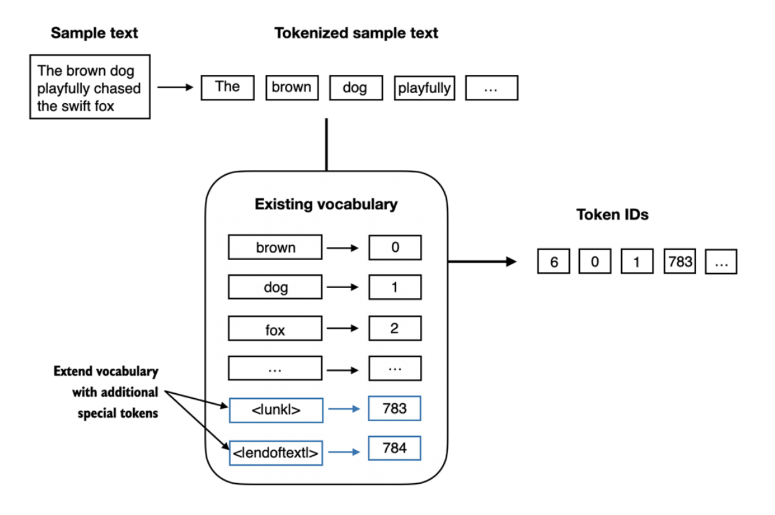

In [75]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [76]:
print(len(vocab.items()))

1132


In [77]:
for i, item in enumerate(list(vocab.items())[-5:]):
  print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [78]:
# first version of the tokenizer
class SimpleTokenizerV2:
  def __init__(self, vocab):
    # vocab (token -> ID)
    self.str_to_int = vocab
    # inverted vocab (ID -> token)
    self.int_to_string = {i:s for s,i in vocab.items()}

  # text -> IDs
  def encode(self, text):
    preprocessed = re.split(r'([,.;:?_!"()\']|--|\s)', text)
    preprocessed = [
        item.strip() for item in preprocessed if item.strip()
    ]
    # solves the unknown words problem with a specific token
    preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  # IDs -> text
  def decode(self, ids):
    text = " ".join([self.int_to_string[i] for i in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [79]:
# test
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


A seconda del LLM considerato possono essere impiegati diversi tipi di token speciali. Nel caso di GPT solamente il token <|endoftext|> viene impiegato. Il token <|unk|> non e necessario per il tipo di tokenizer che viene utilizzato.

# 2.5 Byte Pair Encoding

non implementeremo questo particolare tokenizer, ma ne useremo una versione che e possibile scaricare da terminale.

In [80]:
!pip install tiktoken

In [81]:
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.12.0


In [82]:
tokenizer = tiktoken.get_encoding("gpt2")

In [83]:
text = """Hello, do you like tea? <|endoftext|> In the sunlit terraces of
someunknownPlace."""
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 198, 11246, 34680, 27271, 13]


In [84]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of
someunknownPlace.


*Osservazione 1*

Il vocabolario contiene 50256 token differenti, di cui l'ultimo e il token `<|endoftext|>`

In [85]:
text = "Akwirw ier"
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

[33901, 86, 343, 86, 220, 959]
Akwirw ier


*Osservazione 2*

I token non sono parole singole come per la versione da noi implementate, ma stringhe di caratteri piu o meno lunghe. Questo permette al tokenizer di gestire ogni parola, anche quelle che non si torvano all'interno del vocabolario. Per questo motivo non e necessario l'utilizzo del token `<|unk|>`

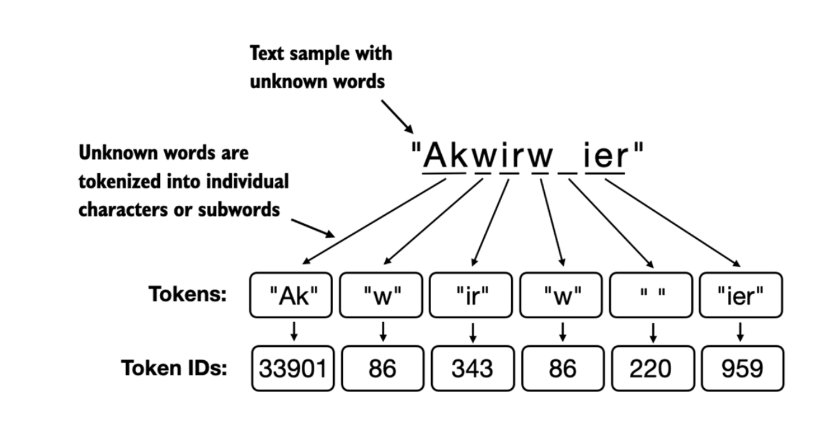

The BPE vocabulary is built by merging frequent n-1-grams into n-grams, considering their text frequencies.

# 2.6 Data Sampling with a sliding window

In [86]:
# encoding The verdict using BPE
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5146


In [87]:
# considering an interesting text passage
enc_sample = enc_text[50:]

In [88]:
# coppie di training input-output per il modello
context_size = 4

for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(context, "----> ", desired)

print('')

for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(tokenizer.decode(context), "----> ", tokenizer.decode([desired]))

[290] ---->  4920
[290, 4920] ---->  2241
[290, 4920, 2241] ---->  287
[290, 4920, 2241, 287] ---->  257

 and ---->   established
 and established ---->   himself
 and established himself ---->   in
 and established himself in ---->   a


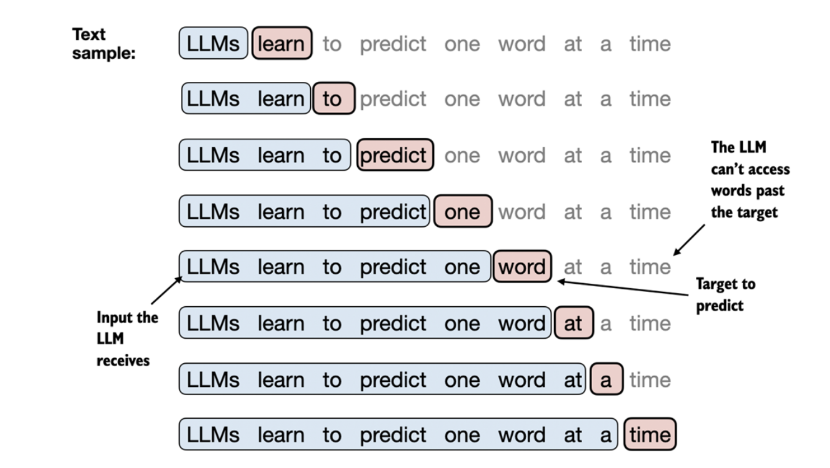

The decoder we are building (GPT3) is trained in a self-supervised way. Given an input sentende it has to learn to predict the next word in the sentence.

In order to procide this kind of training batches we build ad-hoc dataloaders and datasets through the Pytorch API.

In [89]:
# dataset
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt) # using BPE

    # crea le coppie input-input secondo una finestra mobile di larghezza max_length
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+1+max_length]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [90]:
# dataloader
def create_dataloader_v1(txt, batch_zise=4, max_length = 256,
                         stride = 128, shuffle = True, drop_last = True,
                         num_workers = 0):
  # shuffle: if the elements in each batch should be shuffled or not
  # stride: number of positions shift across batches (sliding window approach)
  # max_length: numebr of tokens in each batch
  # batch_size: number of input-output pairs in each batch
  tokenizer = tiktoken.get_encoding("gpt2") # BPE
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_zise,
      shuffle=shuffle,
      drop_last = drop_last, # frops last batch if smaller than fixed batch_size
      num_workers = num_workers # CPU Number used during training
  )

  return dataloader

In [91]:
# test 1: stride effect
dataloader = create_dataloader_v1(
    raw_text, batch_zise= 1, max_length = 8, stride = 3, shuffle = False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]
[tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]]), tensor([[ 1807,  3619,   402,   271, 10899,  2138,   257,  7026]])]


In [92]:
# test 2: max_length effect
dataloader = create_dataloader_v1(
    raw_text, batch_zise= 1, max_length = 2, stride = 2, shuffle = False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

second_batch = next(data_iter)
print(second_batch)

[tensor([[ 40, 367]]), tensor([[ 367, 2885]])]
[tensor([[2885, 1464]]), tensor([[1464, 1807]])]


In [93]:
# test 3: batch_size effect
dataloader = create_dataloader_v1(
    raw_text, batch_zise= 8, max_length = 4, stride = 4, shuffle = False
)
data_iter = iter(dataloader)
input, target = next(data_iter)
print("input: ", input)
print("output: ", target)

input:  tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
output:  tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


To avoid model overfitting during training we set max_length to 4 to utilize the dataset fully, minimizing the overlap between the batches.

# 2.7 Creating Token Embeddings

L'ultimo passaggio del preprocessing e quello di trasformare il token ID in un vettore di embedding.

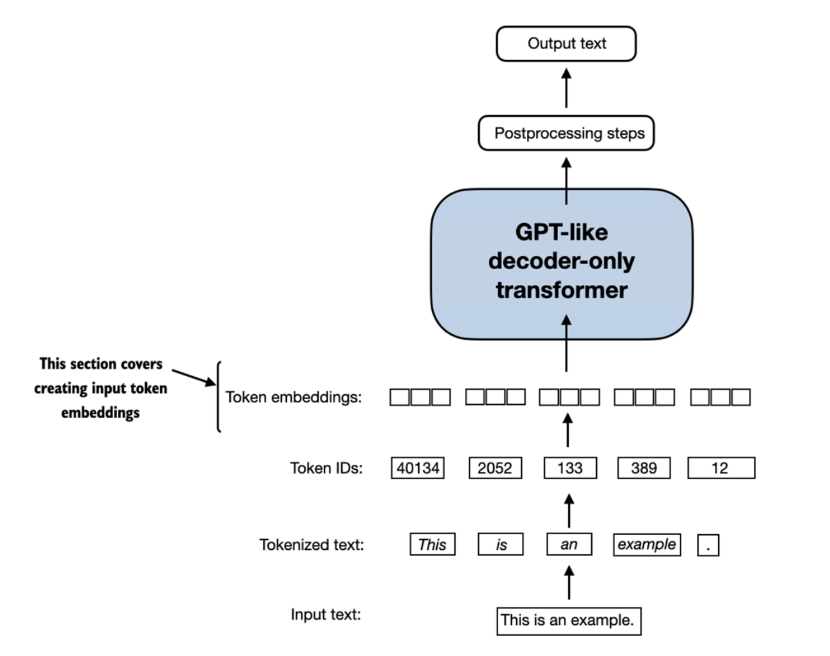

In [95]:
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3
torch.manual_seed(123)

# embedding matrix of the dictionary randomly initialized
embedding_layer = torch.nn.Embedding(vocab_size, output_dim) # matrice dei pesi (dizionario di embeddding)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


Applicare la matrice di embedding a un token ID corrisponde a estrarre la riga corrispondente dalla matrice di embedding. Questa è un'implementazione efficiente di una moltiplicazione tra un vettore one-hot e la matrice dei pesi.

Infatti, vedendo il token ID come un vettore one-hot con un 1 in corrispondenza del token ID, è possibile pensare all'operazione di embedding come a una rete neurale completamente connessa.

Si definisca:
- $X \in M(N,D)$ - matrice di input di N parole prese da un dizionario con D termini. È formata da vettori one-hot.
- $Y \in M(N,K)$ - matrice di embedding che contiene la rappresentazione dei token nello spazio di embedding
- $W \in M(D,K)$ - matrice dei pesi.

L'operazione che permette di trasformare i token in vettori di embedding è la seguente:
$$XW=Y$$

La matrice dei pesi W viene imparata dal modello durante la fase di training.

La sua interpretazione è fondamentale: **dizionario di embedding**. Raggruppa per riga l'embedding di dimensione K di tutti i D vettori del dizionario. Ogni elemento (riga) dell'output Y non è altro che la riga in posizione token-ID della matrice W (dizionario di embedding).

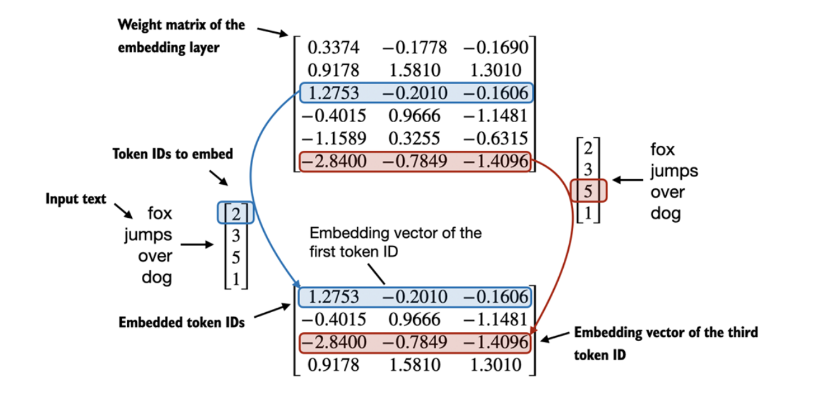

In [96]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


# 2.8 Encodng Word Positions

Un problema importante di questo tipo di encoding e quello di non tenere conto dell'ordine dell'input. Infatti per coma abbiamo implementato l'operazione di encoding e poi embedding, una parola avra lo stesso embedding indipendentemente dalla sua posizione all'interno della frase.

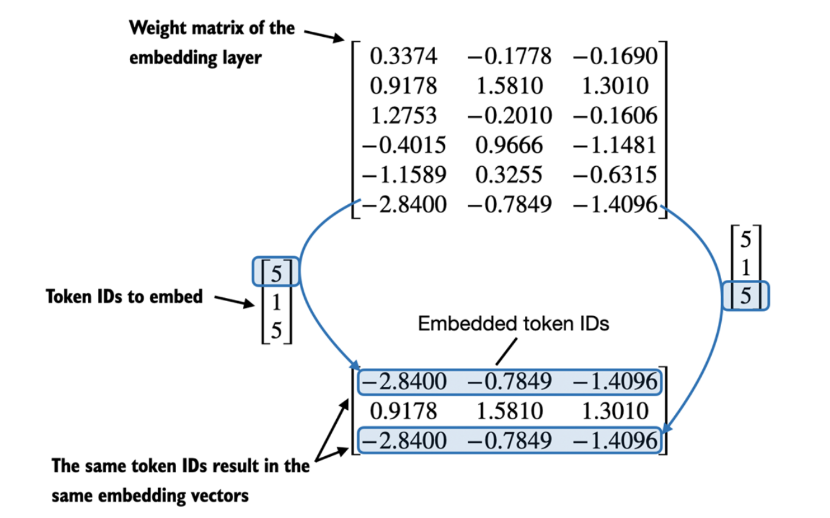

Un modo risolvere questo problema e quello di aggiungere un embedding posizionale ad token embedding ottenuto. In genere questi embedding posizionali vengono ottimizzati durante l'allenamento del modello

In [100]:
vocab_size = 50257 # parole nel dizionario
output_dim = 256 # dimenzione dello spazio di embedding
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim) # matrice dei pesi (dizionario di embedding)

In [103]:
max_length = 4
dataloader = create_dataloader_v1(
  raw_text, batch_zise = 8, max_length = max_length,
  stride = max_length, shuffle = False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs: \n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [104]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


Ogni parola e stata 'tradotta' nello spazio di embedding tramite la matrice dei pesi $W$, che prima abbiamo definito dizionario di embedding. L'output del layer di embedding e uguale ad un tensore tridimensionale.

Ogni token-ID (vettore one-hot) e proiettato in uno spazio di embedding a 256 dimensioni.

In [105]:
# embedding posizionale
pos_embedding_layer = torch.nn.Embedding(max_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


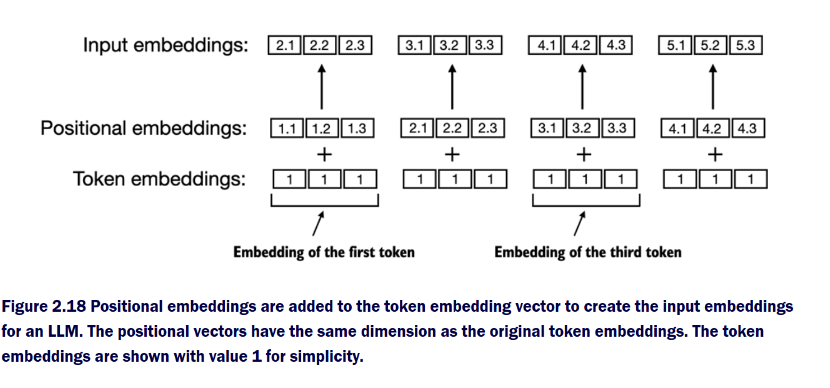

In [106]:
print(pos_embeddings)

tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)


In [110]:
input_embeddings = token_embeddings + pos_embeddings # aggiunta del'embedding posizionale ad ogni batch
print(input_embeddings.shape)

torch.Size([8, 4, 256])
